In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import math

def initial_condition(x):
    return 50000 * np.sin(np.pi *(x+1)/2)

def boundary_conditions_neuman(B, dx):
    B[0] = B[1] - dx * (B[2] - B[0]) / (2 * dx)  
    B[-1] = B[-2] + dx * (B[-2] - B[-3]) / (2 * dx)  

def create_A(r, Nx):
    A = np.zeros((Nx - 1, Nx - 1))
    for i in range(Nx - 1):
        A[i, i] = 1 + 2 * r
        if i > 0:
            A[i, i - 1] = -r
        if i < Nx - 2:
            A[i, i + 1] = -r
    return A

def create_B_matrix(r, Nx):
    B_matrix = np.zeros((Nx - 1, Nx - 1))
    for i in range(Nx - 1):
        B_matrix[i, i] = 1 - 2 * r
        if i > 0:
            B_matrix[i, i - 1] = r
        if i < Nx - 2:
            B_matrix[i, i + 1] = r
    return B_matrix

def crank_nicolson_magnetic_diffusion(x, t, eta, Nx, Nt, L, T, initial, boundary):
    dx = L / Nx
    dt = T / Nt
    r = eta * dt / (2 * dx**2)
    B = np.zeros((Nx+1, Nt+1))
    B[:, 0] = initial(x)
    A = create_A(r, Nx)
    B_matrix = create_B_matrix(r, Nx)
    for j in range(Nt):
        boundary(B[:, j], dx)
        B[1:-1, j+1] = np.linalg.solve(A, np.dot(B_matrix, B[1:-1, j]))
    return B

def calculate_B_i(eta, Nx, Nt, L, T, method=crank_nicolson_magnetic_diffusion, initial=initial_condition, boundary=boundary_conditions, show_graph=1):
    # Grid
    x = np.linspace(-1, 1, Nx+1)  # Normalized spatial grid
    t = np.linspace(0, T, Nt+1)    # Time grid
    dx = x[1] - x[0]
    dt = t[1] - t[0]
    # Solve magnetic field diffusion equation using Crank-Nicolson method
    magnetic_field = method(x, t, eta, Nx, Nt, L, T, initial, boundary)
    if show_graph==1:
        # Contour 
        plt.figure(figsize=(10, 6))
        levels = np.linspace(np.min(magnetic_field), np.max(magnetic_field), 20)
        plt.contourf(x, t, magnetic_field.T, levels=levels, cmap='plasma')
        cbar = plt.colorbar(label='Magnetic Field')
        cbar.set_label('Magnetic Field', rotation=270, labelpad=15)
        plt.show()
    return magnetic_field

def decay_B(B, show_graph=1):
    middle_index = len(B) // 2
    thirds = len(B) // 3
    B_middle = B[middle_index, :]
    B_thirds = B[thirds, :]

    def exponential_func(t, B0, gamma):
        return B0 * np.exp(gamma * t)

    t_fit = np.linspace(0, T, Nt+1)  
    popt, pcov = curve_fit(exponential_func, t_fit, B_middle)  # popt=[B0, gamma]
    popt1, pcov1 = curve_fit(exponential_func, t_fit, B_thirds)
    print("Gamma from z=0:", popt[1])
    print("Gamma from z=-h/3:", popt1[1])
    
    if show_graph:
        log_B = np.log(B_middle)
        log_B1 = np.log(B_thirds)
        plt.plot(t_fit, log_B, label=f"at z=0,$\gamma$={popt[1]}")
        plt.plot(t_fit, log_B1, label=f"at z=-h/3,$\gamma$={popt1[1]}")
        plt.ylabel("log B")
        plt.xlabel("T")
        plt.title("log B vs T")
        plt.grid()
        plt.legend()
        plt.show()
    
    return popt[1]

def get_pitch(MeanBR, MeanBPhi):
    pitch_values = []
    for i in range(0, len(MeanBR)):
        pitch_values.append(math.atan(MeanBR[i] / MeanBPhi[i]))
    return pitch_values

def get_mean_field_B(B_i):
    meanB_t = []
    for i in range(0, len(B_i)):
        meanB_t.append(np.mean(B_i[:, i]))
    return meanB_t

# Example usage:
Nx = 100  # Number of spatial grid points
Nt = 1000  # Number of time steps
L = 2  # Length of the domain
T = 1  # Total time
eta = 1e-1  # Diffusion coefficient



In [4]:
def plot_all(eta,Nx,Nt,L,T,magnetic_field=calculate_B_i,method=crank_nicolson_magnetic_diffusion,initial=initial_condition,boundary=boundary_conditions,show_graph=1,show_decay=1):
    B_z=magnetic_field(eta,Nx,Nt,L,T,method,initial,boundary,show_graph)
    B_r=magnetic_field(eta,Nx,Nt,L,T,method,initial,boundary,0)
    B_phi=magnetic_field(eta,Nx,Nt,L,T,method,initial,boundary,0)
    gamma=decay_B(B_z,show_graph)
    print(f"Decay($gamma$):{gamma}.")
    pitch=np.mean(get_pitch(get_mean_field_B(B_r),get_mean_field_B(B_phi)))
    print(f"Pitch angle {pitch} which is {pitch/np.pi}\u03C0 .")
    return B_z



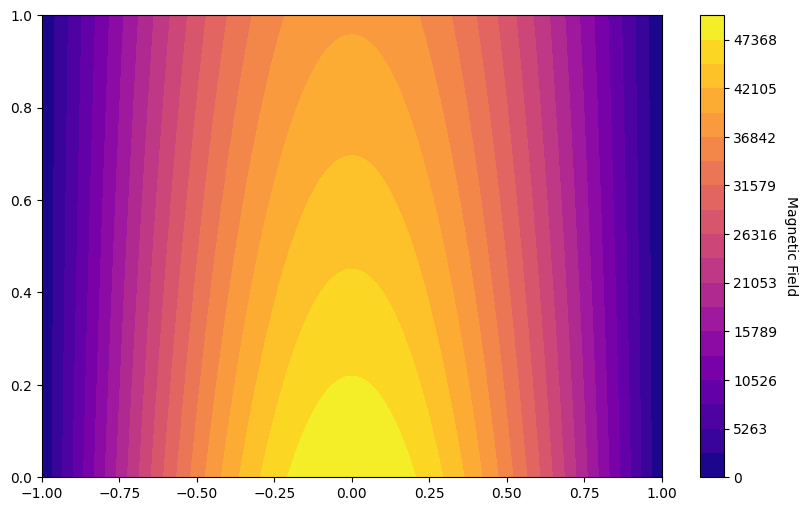

Gamma from z=0: -0.2467198183856655
Gamma from z=-h/3: -0.246719818385666


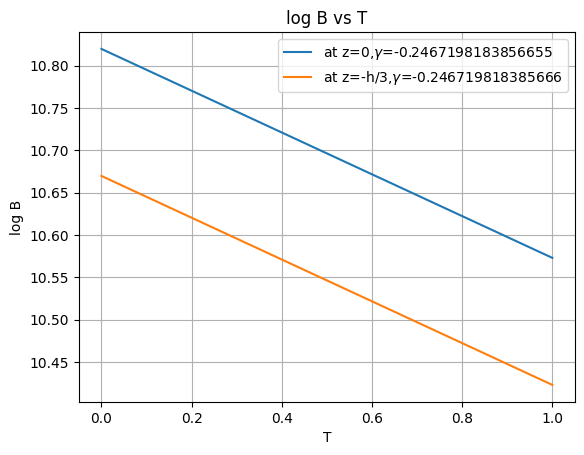

Decay($gamma$):-0.2467198183856655.
Pitch angle 0.7853981633974482 which is 0.24999999999999997π .


In [5]:
B_z=plot_all(eta,Nx,Nt,L,T,calculate_B_i)